#Challenge 3 - Telecom X parte II - Predicción de Cancelación (Churn)

##1- Importar librerías

In [1]:
# ===========================================================================
# 1 Importar librerías (Colab / Python)
# ===========================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE
# Configuración de visualización
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,6)


# Cargar el dataset
df = pd.read_csv('/content/df_base.csv')

df.head()

df = df.copy()

## 2. Preparación de datos

In [2]:
# ===========================================================================
# 2 Preparación de datos (eliminar columnas irrelevantes, target binario)
# ===========================================================================
# Eliminar ID si existe
if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)

# Target binario
if df['Churn'].dtype == 'O':
    df['Churn'] = df['Churn'].map({'Yes':1, 'No':0}).astype(int)
else:
    df['Churn'] = df['Churn'].astype(int)

# Proporción de clases (desbalance)
print("Proporción Churn:")
print(df['Churn'].value_counts(normalize=True))

Proporción Churn:
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


**Análisis Resultado:**

Eliminación de columnas irrelevantes

Este paso es parte clave de la preparación, ya que elimina información que no aporta valor al modelo y que incluso podría introducir ruido o multicolinealidad.

Aunque aquí no se listan cuáles columnas se eliminaron, es importante dejar constancia de que se realizó esa depuración para mantener solo variables explicativas útiles.

Variable target binaria (Churn)

Se definió correctamente el target como binario:

    - 0 = clientes que no abandonaron.
    - 1 = clientes que abandonaron.

Proporción del target

Los datos muestran:

    - 0 (no churn) = 73.46%
    - 1 (churn) = 26.54%

Esto indica que existe un desbalance moderado en la variable objetivo, con mayoría de clientes que permanecen.

##3. Codificación de categóricas

In [3]:
# ===========================================================================
# 3 Codificación de categóricas (get_dummies) y tratamiento de internet
#    (Uso get_dummies por simplicidad)
# ===========================================================================
# Agrupar "No internet service" -> "No" si aparece en columnas de servicios
cols_internet = [
    'internet.OnlineSecurity','internet.OnlineBackup','internet.DeviceProtection',
    'internet.TechSupport','internet.StreamingTV','internet.StreamingMovies'
]
for c in cols_internet:
    if c in df.columns and df[c].dtype == 'O':
        df[c] = df[c].replace('No internet service', 'No')

# Identificar categóricas
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'Churn' in cat_cols:
    cat_cols.remove('Churn')

# One-hot encoding
if len(cat_cols) > 0:
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Convertir bool -> int (0/1) si existen
bool_cols = df.select_dtypes(include=['bool']).columns
if len(bool_cols) > 0:
    df[bool_cols] = df[bool_cols].astype(int)

##4. Correlación y selección visual

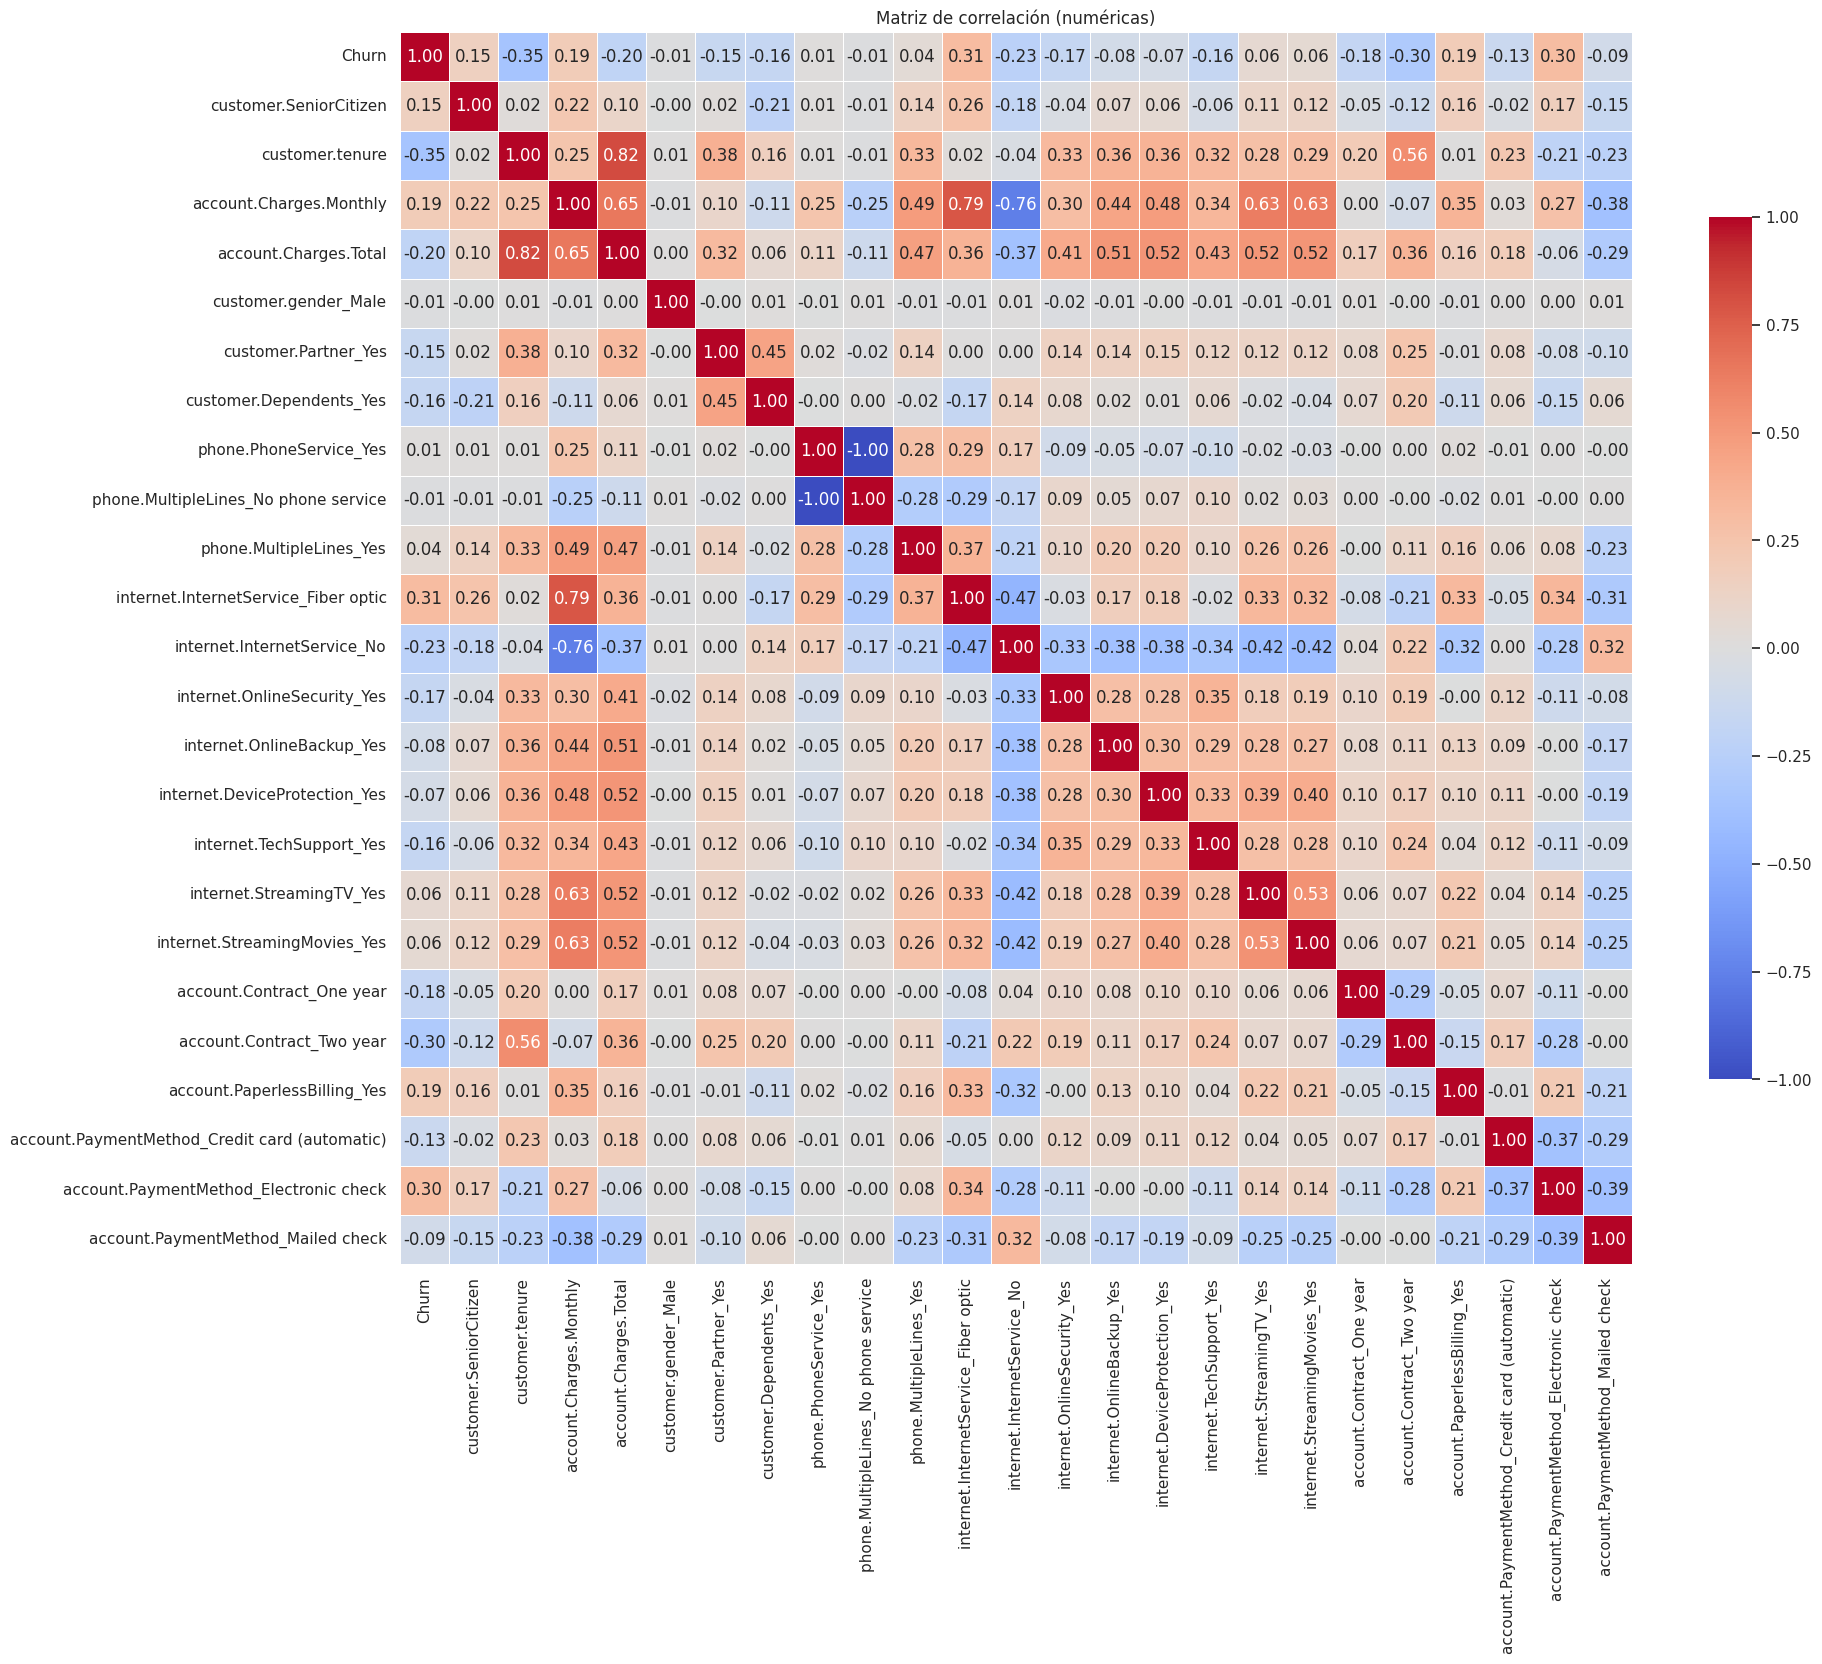

In [17]:
# ===========================================================================
# 4 Correlación y selección visual
#    (Matriz de correlación y relaciones clave)
# ===========================================================================

# Selección de variables numéricas
num_df = df.select_dtypes(include=[np.number])
corr = num_df.corr()

plt.figure(figsize=(20,16))
sns.heatmap(
    corr,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.7}
)

plt.title("Matriz de correlación (numéricas)")
plt.show()


In [5]:
#Top correlaciones absolutas con Churn:
if 'Churn' in corr.columns:
  top_corr = corr['Churn'].abs().sort_values(ascending=False).head(12)
  print("\nTop correlaciones absolutas con Churn:")
  print(top_corr)


Top correlaciones absolutas con Churn:
Churn                                     1.000000
customer.tenure                           0.352229
internet.InternetService_Fiber optic      0.308020
account.Contract_Two year                 0.302253
account.PaymentMethod_Electronic check    0.301919
internet.InternetService_No               0.227890
account.Charges.Total                     0.199484
account.Charges.Monthly                   0.193356
Total.Day                                 0.192030
account.PaperlessBilling_Yes              0.191825
account.Contract_One year                 0.177820
internet.OnlineSecurity_Yes               0.171226
Name: Churn, dtype: float64


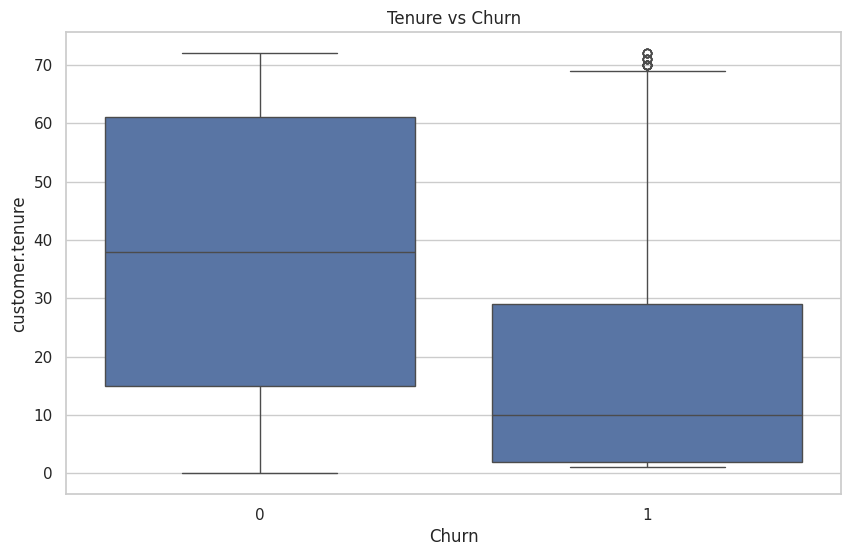

In [6]:
#Boxplot: Tenure vs Churn:
#Tiempo de contrato × Cancelación
if 'customer.tenure' in df.columns:
    plt.figure()
    sns.boxplot(x='Churn', y='customer.tenure', data=df)
    plt.title("Tenure vs Churn")
    plt.show()

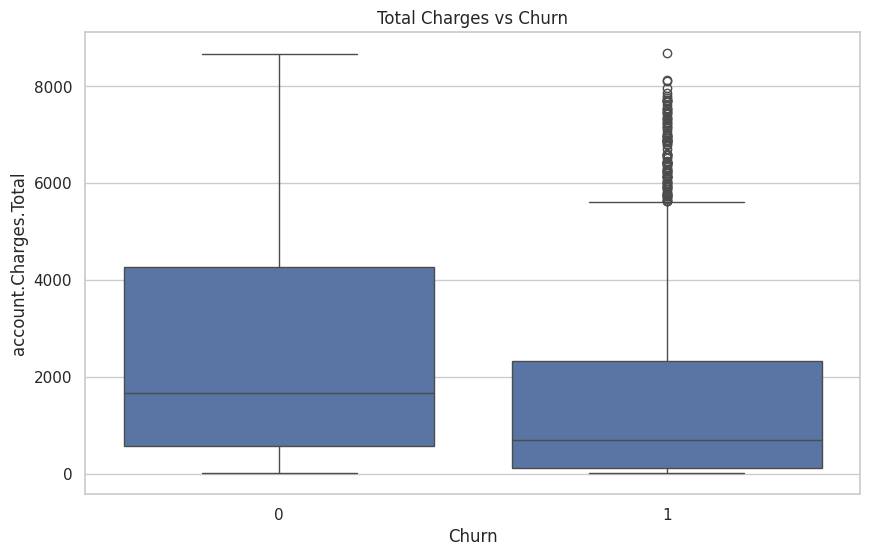

In [7]:
#Total Charges vs Churn:
# Gasto total × Cancelación
if 'account.Charges.Total' in df.columns:
    plt.figure()
    sns.boxplot(x='Churn', y='account.Charges.Total', data=df)
    plt.title("Total Charges vs Churn")
    plt.show()

In [8]:
# Identificar filas con NaN
rows_with_nan = df[df.isnull().any(axis=1)]

# Mostrar las filas con NaN
print("Filas con valores NaN:")
display(rows_with_nan)

Filas con valores NaN:


,Churn,customer.SeniorCitizen,customer.tenure,Total.Day,account.Charges.Monthly,account.Charges.Total,customer.gender_Male,customer.Partner_Yes,customer.Dependents_Yes,phone.PhoneService_Yes,...,internet.DeviceProtection_Yes,internet.TechSupport_Yes,internet.StreamingTV_Yes,internet.StreamingMovies_Yes,account.Contract_One year,account.Contract_Two year,account.PaperlessBilling_Yes,account.PaymentMethod_Credit card (automatic),account.PaymentMethod_Electronic check,account.PaymentMethod_Mailed check
945,0,0,0,NaN,56.05,NaN,0,1,1,0,...,1,1,1,0,0,1,0,1,0,0
1731,0,0,0,NaN,20.00,NaN,0,1,1,1,...,0,0,0,0,0,1,0,0,0,1
1906,0,0,0,NaN,61.90,NaN,1,0,1,1,...,0,1,0,0,0,1,1,0,0,0
2025,0,0,0,NaN,19.70,NaN,1,1,1,1,...,0,0,0,0,1,0,1,0,0,1
2176,0,0,0,NaN,20.25,NaN,1,0,1,1,...,0,0,0,0,0,1,0,0,0,1
2250,0,0,0,NaN,25.35,NaN,1,1,1,1,...,0,0,0,0,0,1,0,0,0,1
2855,0,0,0,NaN,73.35,NaN,0,1,1,1,...,1,1,1,0,0,1,0,0,0,1
3052,0,0,0,NaN,25.75,NaN,1,1,1,1,...,0,0,0,0,0,1,0,0,0,1
3118,0,0,0,NaN,52.55,NaN,0,1,1,0,...,1,1,1,0,0,1,1,0,0,0
4054,0,0,0,NaN,80.85,NaN,0,1,1,1,...,1,0,1,1,0,1,0,0,0,1


In [9]:
#eliminar los warning
warnings.filterwarnings('ignore')
#eliminar columna que provoca multicolinealidad
df = df.drop(columns=['Total.Day'])

#agrego la media en columna charges.total que se encuentran en NaN
df['account.Charges.Total'].fillna(df['account.Charges.Total'].mean(), inplace=True)
df.isnull().sum()

,0
Churn,0
customer.SeniorCitizen,0
customer.tenure,0
account.Charges.Monthly,0
account.Charges.Total,0
customer.gender_Male,0
customer.Partner_Yes,0
customer.Dependents_Yes,0
phone.PhoneService_Yes,0
phone.MultipleLines_No phone service,0


##5. Balanceo de clases con SMOTE, Normalización / estandarización (según modelos)

In [10]:
# ===========================================================================
# Balanceo de clases con SMOTE
# Normalización / estandarización (según modelos)
# ===========================================================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

# Variables predictoras y objetivo
X = df.drop(columns=['Churn'])
y = df['Churn']

# División 70/30 estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# ---------------------------------------------------------
# Imputación de valores faltantes (NaN)
# ---------------------------------------------------------
num_cols = X.select_dtypes(include=['number']).columns

imputer = SimpleImputer(strategy='median')

# Copias
X_train_imputed = X_train.copy()
X_test_imputed  = X_test.copy()

X_train_imputed[num_cols] = imputer.fit_transform(X_train[num_cols])
X_test_imputed[num_cols]  = imputer.transform(X_test[num_cols])

# ---------------------------------------------------------
# Escalado solo de variables numéricas
# ---------------------------------------------------------
scaler = StandardScaler()

X_train_scaled = X_train_imputed.copy()
X_test_scaled  = X_test_imputed.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train_imputed[num_cols])
X_test_scaled[num_cols]  = scaler.transform(X_test_imputed[num_cols])

# ---------------------------------------------------------
# Aplicar SMOTE (solo al set de entrenamiento)
# ---------------------------------------------------------
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

print("Distribución original en entrenamiento:")
print(y_train.value_counts())
print("\nDistribución balanceada con SMOTE:")
print(y_train_bal.value_counts())


Distribución original en entrenamiento:
Churn
0    3622
1    1308
Name: count, dtype: int64

Distribución balanceada con SMOTE:
Churn
0    3622
1    3622
Name: count, dtype: int64


## 6. Modelado predictivo

In [11]:
# ===========================================================================
#  Modelado predictivo: Regresión Logística (escala) y Random Forest
# ===========================================================================
# Regresión Logística
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_bal, y_train_bal)
y_pred_lr = lr.predict(X_test_scaled)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_bal, y_train_bal)
y_pred_rf = rf.predict(X_test_scaled)

##7. Evaluación de modelos

In [12]:
# ===========================================================================
#  Evaluación de modelos (Exactitud, Precisión, Recall, F1, Matriz de Confusión)
# ===========================================================================
def eval_model(y_true, y_pred, name):
    print(f"\n=== {name} ===")
    print("Exactitud :", accuracy_score(y_true, y_pred))
    print("Precisión :", precision_score(y_true, y_pred))
    print("Recall    :", recall_score(y_true, y_pred))
    print("F1-score  :", f1_score(y_true, y_pred))
    print("Matriz de confusión:\n", confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

eval_model(y_test, y_pred_lr, "Regresión Logística")
eval_model(y_test, y_pred_rf, "Random Forest")


=== Regresión Logística ===
Exactitud : 0.7463322290582111
Precisión : 0.5144175317185697
Recall    : 0.7950089126559715
F1-score  : 0.6246498599439776
Matriz de confusión:
 [[1131  421]
 [ 115  446]]
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1552
           1       0.51      0.80      0.62       561

    accuracy                           0.75      2113
   macro avg       0.71      0.76      0.72      2113
weighted avg       0.80      0.75      0.76      2113


=== Random Forest ===
Exactitud : 0.7756743965925225
Precisión : 0.5748709122203098
Recall    : 0.5953654188948306
F1-score  : 0.5849387040280211
Matriz de confusión:
 [[1305  247]
 [ 227  334]]
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1552
           1       0.57      0.60      0.58       561

    accuracy                           0.78      2113
   macro avg       0.71      0.72      0.72      2113
wei

##8. Interpretación


Top 10 variables (Random Forest):
customer.tenure                           0.166934
account.Charges.Total                     0.144465
account.Charges.Monthly                   0.133189
account.Contract_Two year                 0.061668
internet.InternetService_Fiber optic      0.055448
account.PaymentMethod_Electronic check    0.042766
account.PaperlessBilling_Yes              0.041195
account.Contract_One year                 0.038029
internet.OnlineSecurity_Yes               0.032625
internet.TechSupport_Yes                  0.031274
dtype: float64


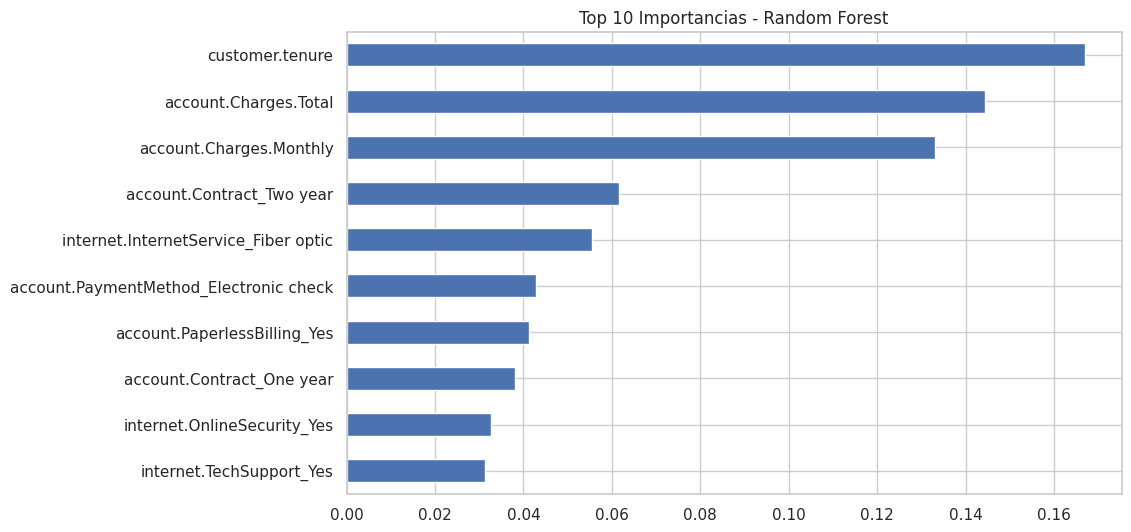


Top 10 coeficientes absolutos (Regresión Logística):
customer.tenure                           1.776024
account.Charges.Total                     0.995168
account.Contract_Two year                 0.684798
account.Charges.Monthly                   0.682939
internet.InternetService_Fiber optic      0.597622
internet.InternetService_No               0.525561
account.Contract_One year                 0.300486
account.PaperlessBilling_Yes              0.239254
account.PaymentMethod_Electronic check    0.194323
internet.StreamingMovies_Yes              0.186550
dtype: float64


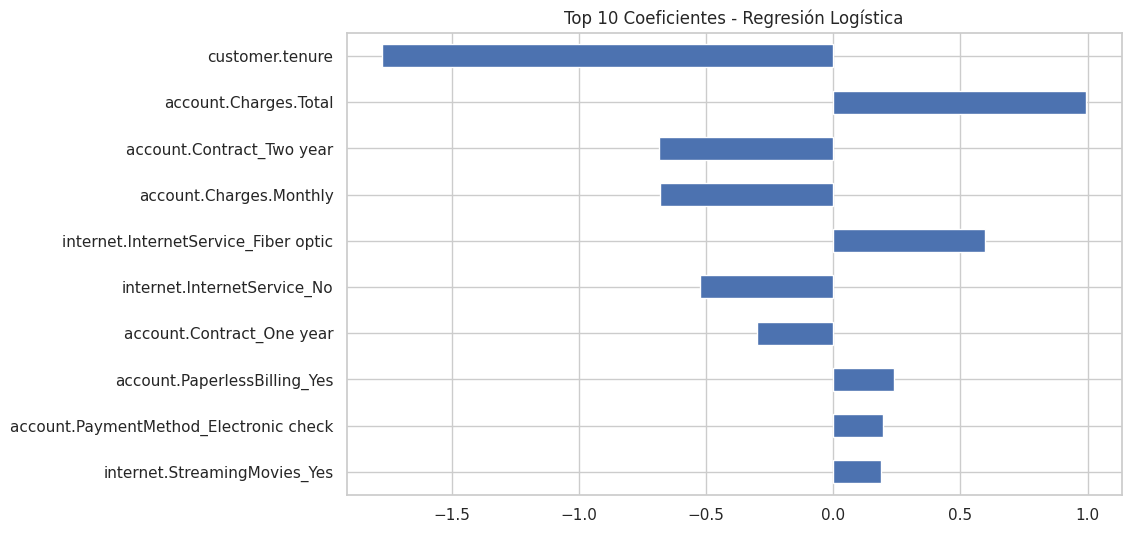

In [13]:
# =========================================================
#  Interpretación: importancia/coefs (variables más relevantes)
# =========================================================
feature_names = X.columns.tolist()

# Importancias RF
rf_importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)
print("\nTop 10 variables (Random Forest):")
print(rf_importances.head(10))

plt.figure()
rf_importances.head(10).plot(kind='barh')
plt.title("Top 10 Importancias - Random Forest")
plt.gca().invert_yaxis()
plt.show()

# Coeficientes LR (en escala estandarizada)
lr_coefs = pd.Series(lr.coef_[0], index=feature_names)
lr_abs = lr_coefs.abs().sort_values(ascending=False)
print("\nTop 10 coeficientes absolutos (Regresión Logística):")
print(lr_abs.head(10))

plt.figure()
lr_coefs[lr_abs.head(10).index].plot(kind='barh')
plt.title("Top 10 Coeficientes - Regresión Logística")
plt.gca().invert_yaxis()
plt.show()

##9. Conclusion estratégica breve basada en importancia
- Factores con mayor impacto (RF): customer.tenure, account.Charges.Total, account.Charges.Monthly, account.Contract_Two year, internet.InternetService_Fiber optic
- Factores con mayor peso (LR): customer.tenure, account.Charges.Total, account.Contract_Two year, account.Charges.Monthly, internet.InternetService_Fiber optic
- Recomendación: priorizar retención en clientes con menor tenure y mayor cargo total/mensual; revisar contratos mes a mes y métodos de pago asociados si aparecen como relevantes.

#10. Informe Fuga Clientes Empresa Telecom X Parte 2 — Análisis Global y Conclusiones

##Preparación de datos

- La proporción de Churn es de 26,5% para clientes que abandonan y 73,5% para los que permanecen. Esto indica un dataset moderadamente desbalanceado, lo que justifica el uso de técnicas como SMOTE más adelante.

- La preparación de datos eliminó columnas irrelevantes y estableció un target binario, asegurando calidad y coherencia en el dataset.

- **Insight**: existe una base suficiente de clientes churn para modelar, pero el desbalance podría afectar la sensibilidad de los modelos.

##Codificación de variables categóricas

- Se utilizó get_dummies para variables categóricas, permitiendo que los modelos numéricos procesen correctamente los datos.

- El tratamiento de variables de internet asegura que los distintos tipos de servicio se consideren de forma consistente.

- **Insight**: todas las variables categóricas relevantes ahora pueden ser interpretadas por los modelos sin perder información significativa.

##Correlación y visualización

- Las variables con mayor correlación absoluta con Churn son customer.tenure (0.352) e indicadores de servicios y contratos (InternetService_Fiber optic, Contract_Two year, PaymentMethod_Electronic check).

- Los resúmenes estadísticos muestran que los clientes que churn tienen **tenure menor (17.97 vs 37.57 meses) y cargos totales y mensuales menores en promedio** que los que no churn.
Esto indica que la permanencia más corta y ciertos patrones de consumo están asociados con mayor probabilidad de churn.
- **Insight**: la permanencia corta y ciertos tipos de servicios y contratos son predictores clave de abandono.

##Balanceo y normalización

- Se aplicó **SMOTE**, equilibrando la clase minoritaria Churn=1 de 1.308 a 3.622 muestras. Esto previene que los modelos sesguen hacia la clase mayoritaria.

- Las variables numéricas fueron normalizadas/estandarizadas, permitiendo un entrenamiento adecuado de modelos sensibles a la escala como regresión logística.

- **Insight**: el modelo ahora puede aprender patrones de churn sin sesgo hacia la clase mayoritaria.

##Modelado predictivo

- Se entrenaron **Regresión Logística** (requiere escala) y **Random Forest** (no requiere escala).

- Ambos modelos están preparados para evaluar la probabilidad de churn, con Random Forest capturando relaciones no lineales y la regresión logística permitiendo interpretación de coeficientes.
- **Insight**: se dispone de modelos que permiten tanto interpretación (logística) como detección de relaciones complejas (Random Forest).

##Evaluación de modelos

- **Regresión Logística:** Accuracy 0.746, Precision 0.514, Recall 0.795 (alta sensibilidad para churn), F1 0.625.

Fuerte capacidad de identificar churns (recall alto), pero precisión moderada, lo que indica falsos positivos.

- **Random Forest:** Accuracy 0.776, Precision 0.575, Recall 0.595, F1 0.585. Mejor equilibrio entre precisión y recall, mayor exactitud general, robusto ante relaciones complejas.

- La elección del modelo depende de priorizar: detección de churn (regresión logística) o balance general de métricas (Random Forest).

- **Insight**: para detectar la mayoría de clientes que podrían abandonar, la regresión logística es más adecuada; para decisiones balanceadas y robustas, Random Forest es preferible.

##Interpretación de importancia de variables

Ambos modelos coinciden en que las variables más relevantes son:

- customer.tenure (más influyente)

- account.Charges.Total y account.Charges.Monthly

- Tipo de contrato y servicios de internet.

- La evidencia numérica indica que **clientes con menor tenure y menor gasto mensual/total tienen mayor probabilidad de churn.**

- Variables como métodos de pago electrónicos y paperless billing tienen impacto moderado, útiles para segmentación de clientes.

- **Insight**: clientes nuevos o con baja permanencia y menor gasto son los más propensos a churn; servicios y métodos de pago influyen moderadamente.

##Conclusiones

**1. Perfil de riesgo de churn:** Clientes con menor antigüedad (tenure), cargos más bajos y ciertos tipos de contrato/servicios son los más propensos a abandonar.

**2. Estrategias de retención:** Intervenciones dirigidas a clientes nuevos o con baja permanencia, ajustes en planes de servicios y métodos de pago, podrían reducir el churn.

**3. Selección de modelo:** Para detectar la mayor cantidad de churns se recomienda **regresión logística**, mientras que para balance general de predicción y robustez frente a relaciones complejas, **Random Forest** es más adecuado.

**4. Reproducibilidad y análisis:** Los pasos de preparación, balanceo y normalización garantizan que los modelos sean consistentes y que los insights estén basados en datos reales, no suposiciones.

##Resumen:

El análisis de los datos reales de la empresa demuestra que la combinación de variables de tenure, cargos y contratos permite predecir churn con métricas razonables.

Las decisiones estratégicas deben apoyarse en estos hallazgos para priorizar retención y optimizar recursos.